In [4]:
import idx2numpy
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import random as rnd
import numpy.typing as npt

L1_SIZE = 56
L2_SIZE = 28
IMAGE_EDGE_SIZE = 28
PIXELS_PER_IMAGE = IMAGE_EDGE_SIZE ** 2
CLASSES_COUNT = 10
ITERATIONS = 500
LEARNING_RATE = 0.15

### Helper functions

In [5]:
def one_hot(labels: npt.ArrayLike) -> npt.NDArray:
    """
    Converts a 1D array of labels (the ground truth) to 2D matrix of shape (10, labels.size) as a probability distribution, 
    where the corresponding row given by the label value has probability of 1.
    
    :labels: The ground truth.
    :return: Encoded values of labels to probability distribution.
    """
    one_hot = np.zeros((10, labels.size))
    one_hot[labels, np.arange(labels.size)] = 1
    return one_hot

def get_accuracy(results: npt.NDArray, labels: npt.ArrayLike) -> float:
    """
    Calculates the accuracy of a neural network from the results of classification by comparing it to the ground truth.

    :results: The forward propagation results.
    :labels: The ground truth.
    :return: The accuracy as a real number. 
    """
    return (np.sum(np.argmax(results, 0) == labels) / labels.size)

def show_some_mistakes(results: npt.NDArray, labels: npt.ArrayLike, data: npt.NDArray, samples = 10) -> None:
    """
    Plots randomly choosen images, which were not classified correctly.

    :results: The forward propagation results.
    :labels: The ground truth.
    :data: The input data of forward propagation, i.e images.
    :samples: The number of shown images, 10 by default.
    """
    results = np.argmax(results, 0)
    i = rnd.randint(0, labels.size)
    j = 0
    while j < samples:
        i = (i + 1) % labels.size
        if results[i] != labels[i]:
            print("labeled:", labels[i], "-- classified:", results[i])
            plt.imshow(data[:, i].reshape((IMAGE_EDGE_SIZE, IMAGE_EDGE_SIZE)), cmap='gray')
            plt.show()
            j += 1

### Non linear functions

In [6]:
def ReLU(L: npt.NDArray) -> npt.NDArray:
    """
    Calculates the Rectified Linear Units of a numpy matrix.
    
    :L: Values of a hidden layer.
    :return: For all nonnegative numbers returns its value, otherwise 0.
    """
    return np.maximum(0, L)

def ReLU_deriv(L: npt.NDArray) -> npt.NDArray:
    """
    Calculates the derivation of ReLu function of a numpy matrix.

    :L: Values of a hidden layer.
    :return: For all positive numbers returns 1, otherwise 0.
    """
    return L > 0

def sigmoid(L: npt.NDArray) -> npt.NDArray:
    """
    Calculates the Sigmoid function of a numpy matrix.
    
    :L: Values of a hidden layer.
    :return: For all indexes with value x returns 1 / (1 + e^(-x)).
    """
    return 1 / (1 + np.exp(-L))

def softmax(L: npt.NDArray) -> npt.NDArray:
    """
    Converts matrix of N values in a row to probability distribution of N outcomes for each row.

    :L: Values of an output layer.
    :return: For all indexes of the given matrix returns the probability of a given index in its row.
    """
    return np.exp(L) / sum(np.exp(L))

### Initialization of weights and biases

In [7]:
def weights_init_2L(size: int, input_size = PIXELS_PER_IMAGE, output_size = CLASSES_COUNT) -> tuple:
    """
    Randomly initilizes weights with real numbers between -0.5 and 0.5.

    :size: Number of neurons in a hidden layer.
    :input_size: Number of input values.
    :output_size: Number of neurons in a hidden layer an output layer.
    :return: Tuple of randomly initilized weight matrices real numbers between -0.5 and 0.5.
    """
    # The order of matrix multiplication with weight matrices is given by the arrangement of weights into columns and rows, see below and in other functions.
    W1 = np.random.rand(size, input_size) - 0.5  # Columns represent weights for input values, that means rows represent weights for hidden layer values.
    W2 = np.random.rand(output_size, size) - 0.5 # Columns represent weights for hidden layer values, that means rows represent weights for output layer values.
    return W1, W2

def weights_init_3L(l1_size: int, l2_size: int, input_size = PIXELS_PER_IMAGE, output_size = CLASSES_COUNT) -> tuple:
    """
    Randomly initilizes weights with real numbers between -0.5 and 0.5.

    :l1_size: Number of neurons in a first hidden layer.
    :l2_size: Number of neurons in a second hidden layer.
    :input_size: Number of input values.
    :output_size: Number of neurons in an output layer.
    :return: Tuple of randomly initilized weight matrices with real numbers between -0.5 and 0.5.
    """
    # The order of matrix multiplication with weight matrices is given by the arrangement of weights into columns and rows, see below and in other functions.
    W1 = np.random.rand(l1_size, input_size) - 0.5   # Columns represent weights for input values, that means rows represent weights for first hidden layer values.
    W2 = np.random.rand(l2_size, l1_size) - 0.5      # Columns represent weights for first hidden layer values, that means rows represent weights for second hidden layer values.
    W3 = np.random.rand(output_size, l2_size) - 0.5  # Columns represent weights for second hidden layer values, that means rows represent weights for output layer values.
    return W1, W2, W3

def weights_init(sizes: list) -> list:
    """
    Randomly initilizes weights with real numbers between -0.5 and 0.5.

    :sizes: List of layer sizes, first value specifies number of input values, last value specifies number of output neurons. 
            Number of initilizes weight matrices is one less than lenght of the given list.
    :return: List of randomly initilized weight matrices with real numbers between -0.5 and 0.5.
    """
    weights = [] 
    for i in range(len(sizes) - 1):
        # The order of matrix multiplication with weight matrices is given by the arrangement of weights into columns and rows, see below and in other functions.
        weights.append(np.random.rand(sizes[i + 1], sizes[i]) - 0.5) # Columns represent weights for Nth layer values, that means rows represent weights for N+1th layer values.
    return weights

def biases_init_2L(size, output_size = 10):
    B1 = np.random.rand(size, 1) - 0.5
    B2 = np.random.rand(output_size, 1) - 0.5
    return B1, B2

def biases_init_3L(l1_size, l2_size, output_size = CLASSES_COUNT):
    B1 = np.random.rand(l1_size, 1) - 0.5
    B2 = np.random.rand(l2_size, 1) - 0.5
    B3 = np.random.rand(output_size, 1) - 0.5
    return B1, B2, B3

def biases_init(sizes):
    biases = []
    for i in range(1, len(sizes)):
        biases.append(np.random.rand(sizes[i], 1) - 0.5)
    return biases

### Adjusting weights and biases after a training cycle

In [8]:
def weights_adjust_2L(W1, W2, dW1, dW2, learning_rate):
    W1 = W1 - learning_rate * dW1
    W2 = W2 - learning_rate * dW2
    return W1, W2

def weights_adjust_3L(W1, W2, W3, dW1, dW2, dW3, learning_rate):
    W1 = W1 - learning_rate * dW1
    W2 = W2 - learning_rate * dW2
    W3 = W3 - learning_rate * dW3
    return W1, W2, W3

def weights_adjust(weights, weight_derivs, learning_rate):
    for i in range(len(weights)):
        weights[i] = weights[i] - learning_rate * weight_derivs[i]
        
    return weights

def biases_adjust_2L(B1, B2, dB1, dB2, learning_rate):
    B1 = B1 - learning_rate * dB1
    B2 = B2 - learning_rate * dB2
    return B1, B2

def biases_adjust_3L(B1, B2, B3, dB1, dB2, dB3, learning_rate):
    B1 = B1 - learning_rate * dB1
    B2 = B2 - learning_rate * dB2
    B3 = B3 - learning_rate * dB3
    return B1, B2, B3

def biases_adjust(biases, bias_derivs, learning_rate):
    for i in range(len(biases)):
        biases[i] = biases[i] - learning_rate * bias_derivs[i]
    
    return biases

### Forward propagation

In [9]:
def forward_prop_2L(W1, W2, B1, B2, training_data):
    Z1 = W1.dot(training_data) + B1
    L1 = ReLU(Z1)
    Z2 = W2.dot(L1) + B2
    L2 = softmax(Z2)
    return L1, L2

def forward_prop_3L(W1, W2, W3, B1, B2, B3, training_data):
    Z1 = W1.dot(training_data) + B1
    L1 = ReLU(Z1)
    Z2 = W2.dot(L1) + B2
    L2 = ReLU(Z2)
    Z3 = W3.dot(L2) + B3
    L3 = softmax(Z3)
    return L1, L2, L3

def forward_prop(weights, biases, activations, training_data):
    layers = []
    input = training_data
    for i in range(len(weights)):
        layers.append(activations[i](weights[i].dot(input) + biases[i]))
        input = layers[i]
    
    return layers

### Backward propagation

In [10]:
def back_prop_2L(L1, L2, W2, training_data, one_hot_labels):
    normalization = one_hot_labels.shape[1]
    dZ2 = L2 - one_hot_labels
    dW2 = dZ2.dot(L1.T) / normalization
    dB2 = np.sum(dZ2) / normalization
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(L1)
    dW1 = dZ1.dot(training_data.T) / normalization
    dB1 = np.sum(dZ1) / normalization
    return dW1, dW2, dB1, dB2

def back_prop_3L(L1, L2, L3, W2, W3, training_data, one_hot_labels):
    normalization = one_hot_labels.shape[1]
    dZ3 = L3 - one_hot_labels
    dW3 = dZ3.dot(L2.T) / normalization
    dB3 = np.sum(dZ3) / normalization
    dZ2 = W3.T.dot(dZ3) * ReLU_deriv(L2)
    dW2 = dZ2.dot(L1.T) / normalization
    dB2 = np.sum(dZ2) / normalization
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(L1)
    dW1 = dZ1.dot(training_data.T) / normalization
    dB1 = np.sum(dZ1) / normalization
    return dW1, dW2, dW3, dB1, dB2, dB3

def back_prop(layers, weights, activation_derivs, training_data, one_hot_labels):
    layers_count = len(layers)
    normalization = one_hot_labels.shape[1]
    weight_derivs = [None] * layers_count
    bias_derivs = [None] * layers_count

    current_deriv = layers[layers_count - 1] - one_hot_labels
    for i in range(layers_count - 1, 0, -1):
        weight_derivs[i] = current_deriv.dot(layers[i - 1].T) / normalization
        bias_derivs[i] = np.sum(current_deriv) / normalization
        current_deriv = weights[i].T.dot(current_deriv) * activation_derivs[i - 1](layers[i - 1])
        
    weight_derivs[0] = current_deriv.dot(training_data.T) / normalization
    bias_derivs[0] = np.sum(current_deriv) / normalization

    return weight_derivs, bias_derivs

### Gradient descend

In [11]:
def gradient_descend_2L(training_data, labels, L1_size, iterations, learning_rate):
    W1, W2 = weights_init_2L(L1_size)
    B1, B2 = biases_init_2L(L1_size)
    labels = one_hot(labels)

    for _ in range(iterations):
        L1, L2 = forward_prop_2L(W1, W2, B1, B2, training_data)
        dW1, dW2, dB1, dB2 = back_prop_2L(L1, L2, W2, training_data, labels)
        W1, W2 = weights_adjust_2L(W1, W2, dW1, dW2, learning_rate)
        B1, B2 = biases_adjust_2L(B1, B2, dB1, dB2, learning_rate)

    return W1, W2, B1, B2

def gradient_descend_3L(training_data, labels, L1_size, L2_size, iterations, learning_rate):
    W1, W2, W3 = weights_init_3L(L1_size, L2_size)
    B1, B2, B3 = biases_init_3L(L1_size, L2_size)
    labels = one_hot(labels)

    for _ in range(iterations):
        L1, L2, L3 = forward_prop_3L(W1, W2, W3, B1, B2, B3, training_data)
        dW1, dW2, dW3, dB1, dB2, dB3 = back_prop_3L(L1, L2, L3, W2, W3, training_data, labels)
        W1, W2, W3 = weights_adjust_3L(W1, W2, W3, dW1, dW2, dW3, learning_rate)
        B1, B2, B3 = biases_adjust_3L(B1, B2, B3, dB1, dB2, dB3, learning_rate)

    return W1, W2, W3, B1, B2, B3

def gradient_descend(training_data, labels, weight_sizes, activations, activation_derivs, iterations, learning_rate):
    weights = weights_init(weight_sizes)
    biases = biases_init(weight_sizes)
    labels = one_hot(labels)

    for _ in range(iterations):
        layers = forward_prop(weights, biases, activations, training_data)
        weight_derivs, bias_derivs = back_prop(layers, weights, activation_derivs, training_data, labels)
        weights = weights_adjust(weights, weight_derivs, learning_rate)
        biases = biases_adjust(biases, bias_derivs, learning_rate)

    return weights, biases

### Training functions

In [12]:
def train_2L(training_data, training_labels, L1_size = L1_SIZE, iterations = ITERATIONS, learning_rate = LEARNING_RATE):
    W1, W2, B1, B2 = gradient_descend_2L(training_data, training_labels, L1_size, iterations, learning_rate)

    np.save("W1_2L.npy", W1)
    np.save("W2_2L.npy", W2)
    np.save("B1_2L.npy", B1)
    np.save("B2_2L.npy", B2)

def train_3L(training_data, training_labels, L1_size = L1_SIZE, L2_size = L2_SIZE, iterations = ITERATIONS, learning_rate = LEARNING_RATE):
    W1, W2, W3, B1, B2, B3 = gradient_descend_3L(training_data, training_labels, L1_size, L2_size, iterations, learning_rate)

    np.save("W1_3L.npy", W1)
    np.save("W2_3L.npy", W2)
    np.save("W3_3L.npy", W3)
    np.save("B1_3L.npy", B1)
    np.save("B2_3L.npy", B2)
    np.save("B3_3L.npy", B3)

def train(training_data, training_labels, weight_sizes, activations, activation_derivs, iterations = ITERATIONS, learning_rate = LEARNING_RATE, 
          files_id = dt.now().strftime("%d-%m-%Y_%H:%M:%S")):
    weights, biases = gradient_descend(training_data, training_labels, weight_sizes, activations, activation_derivs, iterations, learning_rate)
    for i in range(len(weights)):
        j = str(i + 1)
        np.save("W" + j + "_" + files_id + ".npy", weights[i])
        np.save("B" + j + "_" + files_id + ".npy", biases[i])
    

### Funtions for loading of training and testing data

In [13]:
def load_training_data():
    training_data = idx2numpy.convert_from_file("mnist/train-images.idx3-ubyte")
    training_labels = idx2numpy.convert_from_file("mnist/train-labels.idx1-ubyte")
    sample_count = training_data.shape[0]
    training_data = np.reshape(training_data, (sample_count, -1)).T / 255
    return training_data, training_labels

def load_test_data():
    test_data = idx2numpy.convert_from_file("mnist/t10k-images.idx3-ubyte")
    test_labels = idx2numpy.convert_from_file("mnist/t10k-labels.idx1-ubyte")
    sample_count = test_data.shape[0]
    test_data = np.reshape(test_data, (sample_count, -1)).T / 255
    return test_data, test_labels

### Functions for result assessment

In [14]:
def assess_results_2L():
    W1 = np.load("W1_2L.npy")
    W2 = np.load("W2_2L.npy")
    B1 = np.load("B1_2L.npy")
    B2 = np.load("B2_2L.npy")
    print("\n###################### 2 layers results ######################\n")

    training_data, training_labels = load_training_data()
    L1, L2 = forward_prop_2L(W1, W2, B1, B2, training_data)
    print("Accuracy on training set: ", get_accuracy(L2, training_labels))

    test_data, test_labels = load_test_data()
    L1, L2 = forward_prop_2L(W1, W2, B1, B2, test_data)
    print("Accuracy on test set: ", get_accuracy(L2, test_labels))

    show_some_mistakes(L2, test_labels, test_data)

def assess_results_3L():
    W1 = np.load("W1_3L.npy")
    W2 = np.load("W2_3L.npy")
    W3 = np.load("W3_3L.npy")
    B1 = np.load("B1_3L.npy")
    B2 = np.load("B2_3L.npy")
    B3 = np.load("B3_3L.npy")
    print("\n###################### 3 layers results ######################\n")

    training_data, training_labels = load_training_data()
    L1, L2, L3 = forward_prop_3L(W1, W2, W3, B1, B2, B3, training_data)
    print("Accuracy on training set: ", get_accuracy(L3, training_labels))

    test_data, test_labels = load_test_data()
    L1, L2, L3 = forward_prop_3L(W1, W2, W3, B1, B2, B3, test_data)
    print("Accuracy on test set: ", get_accuracy(L3, test_labels))

    show_some_mistakes(L3, test_labels, test_data)

def assess_results(layers_count, activations, files_id):
    weights = []
    biases = []
    for i in range(layers_count):
        j = str(i + 1)
        weights.append(np.load("W" + j + "_" + files_id + ".npy"))
        biases.append(np.load("B" + j + "_" + files_id + ".npy"))
    
    print("\n###################### " + str(layers_count) + " layers results ######################\n")

    training_data, training_labels = load_training_data()
    last_layer = forward_prop(weights, biases, activations, training_data)[layers_count - 1]
    print("Accuracy on training set: ", get_accuracy(last_layer, training_labels))

    test_data, test_labels = load_test_data()
    last_layer = forward_prop(weights, biases, activations, test_data)[layers_count - 1]
    print("Accuracy on test set: ", get_accuracy(last_layer, test_labels))

    show_some_mistakes(last_layer, test_labels, test_data)

### Training

In [15]:
training_data, training_labels = load_training_data()
train_2L(training_data, training_labels)
train_3L(training_data, training_labels)
train(training_data, training_labels, [PIXELS_PER_IMAGE, 112, L1_SIZE, L2_SIZE, CLASSES_COUNT], [ReLU, ReLU, ReLU, softmax], 
      [ReLU_deriv, ReLU_deriv, ReLU_deriv], files_id="4L")

### Result assessment


###################### 2 layers results ######################

Accuracy on training set:  0.9031666666666667
Accuracy on test set:  0.9029
labeled: 2 -- classified: 0


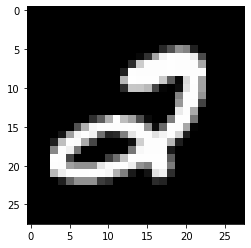

labeled: 3 -- classified: 8


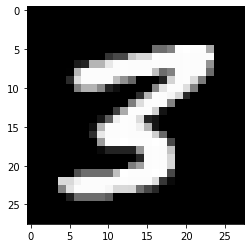

labeled: 7 -- classified: 2


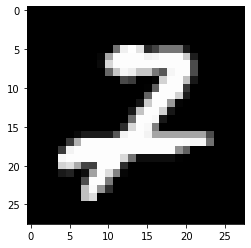

labeled: 5 -- classified: 6


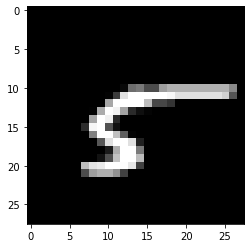

labeled: 7 -- classified: 2


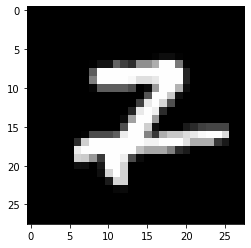

labeled: 7 -- classified: 2


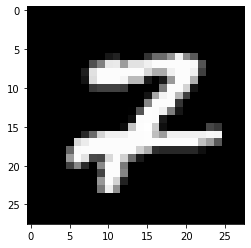

labeled: 7 -- classified: 2


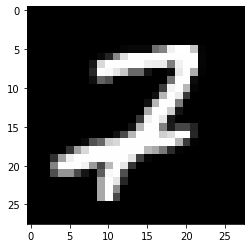

labeled: 9 -- classified: 4


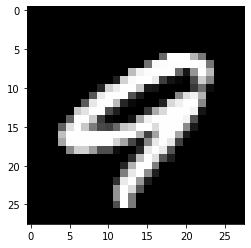

labeled: 7 -- classified: 2


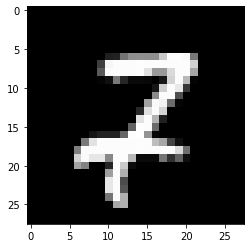

labeled: 7 -- classified: 2


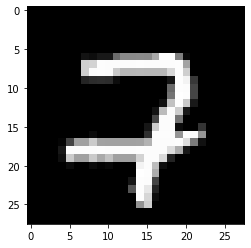


###################### 3 layers results ######################

Accuracy on training set:  0.90955
Accuracy on test set:  0.9099
labeled: 9 -- classified: 0


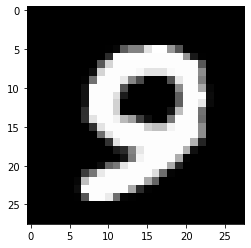

labeled: 9 -- classified: 3


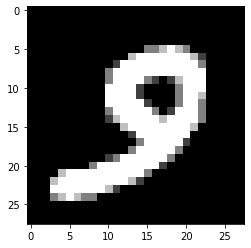

labeled: 9 -- classified: 0


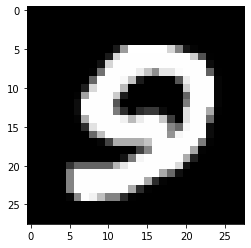

labeled: 9 -- classified: 0


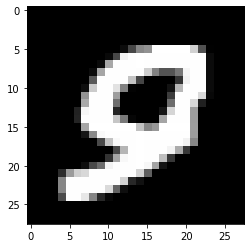

labeled: 3 -- classified: 5


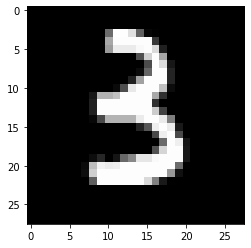

labeled: 5 -- classified: 6


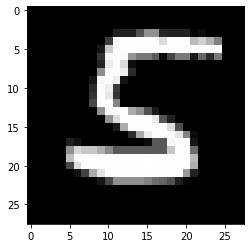

labeled: 8 -- classified: 6


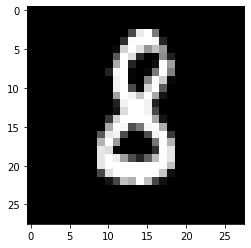

labeled: 2 -- classified: 6


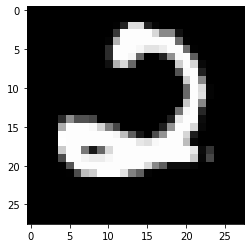

labeled: 8 -- classified: 3


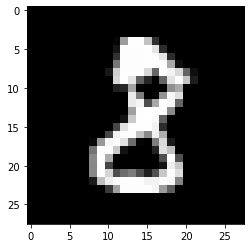

labeled: 3 -- classified: 2


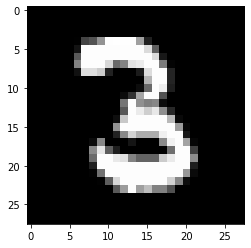


###################### 4 layers results ######################

Accuracy on training set:  0.9166
Accuracy on test set:  0.9094
labeled: 5 -- classified: 3


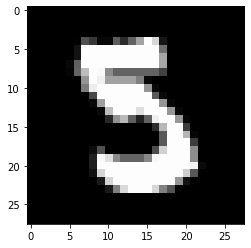

labeled: 5 -- classified: 8


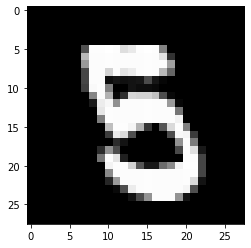

labeled: 7 -- classified: 9


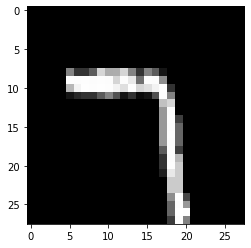

labeled: 6 -- classified: 2


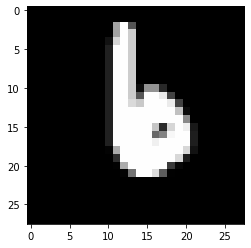

labeled: 4 -- classified: 8


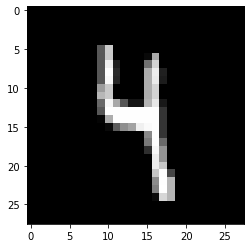

labeled: 2 -- classified: 6


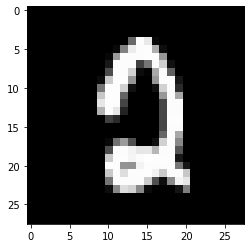

labeled: 4 -- classified: 9


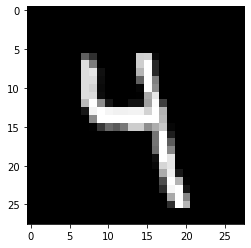

labeled: 5 -- classified: 8


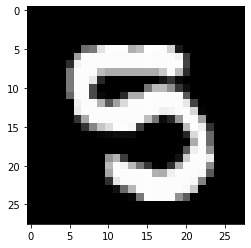

labeled: 5 -- classified: 3


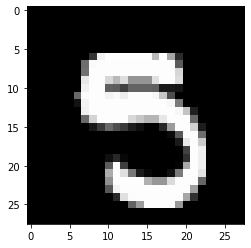

labeled: 3 -- classified: 8


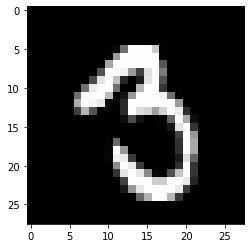

In [16]:
assess_results_2L()
assess_results_3L()
assess_results(4, [ReLU, ReLU, ReLU, softmax], "4L")